# Word Sense Disambiguation (снятие лексической неоднозначности) и Word Sense Induction (нахождение значений слова)

In [ ]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/blob/master/data/wiki_data.txt.zip?raw=true
!wget https://github.com/mannefedov/compling_nlp_hse_course/blob/master/data/corpus_wsd_50k.txt.zip?raw=true
!unzip wiki_data.txt.zip?raw=true
!unzip corpus_wsd_50k.txt.zip?raw=true

import os
os.listdir()

--2021-03-13 15:45:43--  https://github.com/mannefedov/compling_nlp_hse_course/blob/master/data/wiki_data.txt.zip?raw=true
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/wiki_data.txt.zip [following]
--2021-03-13 15:45:43--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/wiki_data.txt.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/wiki_data.txt.zip [following]
--2021-03-13 15:45:43--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/wiki_data.txt.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.gi

['.config',
 'corpus_wsd_50k.txt.zip?raw=true.1',
 'wiki_data.txt.zip?raw=true',
 'wiki_data.txt',
 'wiki_data.txt.zip?raw=true.1',
 'corpus_wsd_50k.txt.zip?raw=true',
 'url?q=https:%2F%2Fgithub.com%2Fmannefedov%2Fcompling_nlp_hse_course%2Fblob%2Fmaster%2Fdata%2Fcorpus_wsd_50k.txt.zip',
 'url?q=https:%2F%2Fgithub.com%2Fmannefedov%2Fcompling_nlp_hse_course%2Fblob%2Fmaster%2Fdata%2Fwiki_data.txt.zip',
 'corpus_wsd_50k.txt',
 '__MACOSX',
 'sample_data']

WSD и WSI  - это связанные задачи про определение значений, в которых употребляются слова. WSI занимается определением возможных значений слова, а WSD нужна для того, чтобы определить, в каком из имеющихся значений слово употреблено в тексте. 

На прошлых занятиях мы вообще закрывали глаза на то, что у слов может быть несколько значений, т.к. в целом это не такая уж серьезная проблема. Однако в некоторых практических задачах учёт многозначности может сильно помочь (например, в поиске результат будет отличаться для запросов "гоголь фильм" и "гоголь писатель")

Основное предположение, на котором строятся все модели для снятия и определения неоднозначности - значение определяется в контексте (отличие от эмбедингов в том, что тут имеется в виду конкретный контекст и конкретное значение, а не набор всех контекстов и общее значение=смысл слова). Т.к контекст может включать в себя невероятного много всего (от 1 соседнего слова до актуальных мемов), решить задачу полностью пока нельзя и это, наверное, сложная и интересная тема для исследований. Про sota в этой области можно почитать вот тут - http://nlpprogress.com/english/word_sense_disambiguation.html  
Но в рамках семинара давайте посмотрим, какие есть уже готовые инструменты или простые алгоритмы для работы с многозначностью.

In [ ]:
!pip install pymorphy2
!pip install razdel

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

А сейчас попробуем Адаграм!

In [ ]:
from lxml import html
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from pymorphy2 import MorphAnalyzer
from string import punctuation
import json, os, re, sys
from collections import Counter
import numpy as np
from razdel import tokenize as razdel_tokenize
from matplotlib import pyplot as plt
import gensim
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import tqdm
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from collections import Counter


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [token.text.strip(punct) for token in list(razdel_tokenize(text))]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return words


## WordNet

Выводить значения просто из текста тяжело, поэтому можно попробовать воспользоваться словарями (wsi сделанное людьми). Для русского придется парсить сайты словарей, а для английского можно воспользоваться WordNet'ом (https://wordnet.princeton.edu/), который есть в nltk.

WordNet - это лексическая база данных, где существительные, прилагательные и глаголы английского сгруппированы по значению. К тому же между ними установлены связи (гипонимия, гипоронимия, миронимия и т.п.).

In [ ]:
# запустите если не установлен ворднет
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Группа синонимичных слов в WordNet'е называются синсеты. 

In [ ]:
# всего синсетов
len(list(wn.all_synsets()))

117659

Из них существительных:

In [ ]:
len(list(wn.all_synsets('n')))

82115

А глаголов:

In [ ]:
len(list(wn.all_synsets('v')))

13767

А прилагательных:

In [ ]:
len(list(wn.all_synsets('a')))

18156

Синсеты для слова можно достать вот так:

In [ ]:
wn.synsets('car')

[Synset('car.n.01'),
 Synset('car.n.02'),
 Synset('car.n.03'),
 Synset('car.n.04'),
 Synset('cable_car.n.01')]

Можно ограничить часть речи:

In [ ]:
wn.synsets('go', pos='v')

[Synset('travel.v.01'),
 Synset('go.v.02'),
 Synset('go.v.03'),
 Synset('become.v.01'),
 Synset('go.v.05'),
 Synset('run.v.05'),
 Synset('run.v.03'),
 Synset('proceed.v.04'),
 Synset('go.v.09'),
 Synset('go.v.10'),
 Synset('sound.v.02'),
 Synset('function.v.01'),
 Synset('run_low.v.01'),
 Synset('move.v.13'),
 Synset('survive.v.01'),
 Synset('go.v.16'),
 Synset('die.v.01'),
 Synset('belong.v.03'),
 Synset('go.v.19'),
 Synset('start.v.09'),
 Synset('move.v.15'),
 Synset('go.v.22'),
 Synset('go.v.23'),
 Synset('blend.v.02'),
 Synset('go.v.25'),
 Synset('fit.v.02'),
 Synset('rifle.v.02'),
 Synset('go.v.28'),
 Synset('plump.v.04'),
 Synset('fail.v.04')]

У многих из них есть определения:

In [ ]:
word = 'day'
for synset in wn.synsets(word):
    print(word + ' - ' + synset.definition())
#     print()

day - time for Earth to make a complete rotation on its axis
day - some point or period in time
day - a day assigned to a particular purpose or observance
day - the time after sunrise and before sunset while it is light outside
day - the recurring hours when you are not sleeping (especially those when you are working)
day - an era of existence or influence
day - the period of time taken by a particular planet (e.g. Mars) to make a complete rotation on its axis
day - the time for one complete rotation of the earth relative to a particular star, about 4 minutes shorter than a mean solar day
day - a period of opportunity
day - United States writer best known for his autobiographical works (1874-1935)


И даже примеры:

In [ ]:
word = 'day'
for synset in wn.synsets(word):
    print(word + ' - ' + ' | '.join(synset.examples()))
#     print()

day - two days later they left | they put on two performances every day | there are 30,000 passengers per day
day - it should arrive any day now | after that day she never trusted him again | those were the days | these days it is not unusual
day - Mother's Day
day - the dawn turned night into day | it is easier to make the repairs in the daytime
day - my day began early this morning | it was a busy day on the stock exchange | she called it a day and went to bed
day - in the day of the dinosaurs | in the days of the Roman Empire | in the days of sailing ships | he was a successful pianist in his day
day - how long is a day on Jupiter?
day - 
day - he deserves his day in court | every dog has his day
day - 


Посмотрим на связанные синсеты (гипонимы, антонимы, синонимы, меронимы).

In [ ]:
s = wn.synsets('car')[0]

In [ ]:
s.part_meronyms()

[Synset('accelerator.n.01'),
 Synset('air_bag.n.01'),
 Synset('auto_accessory.n.01'),
 Synset('automobile_engine.n.01'),
 Synset('automobile_horn.n.01'),
 Synset('buffer.n.06'),
 Synset('bumper.n.02'),
 Synset('car_door.n.01'),
 Synset('car_mirror.n.01'),
 Synset('car_seat.n.01'),
 Synset('car_window.n.01'),
 Synset('fender.n.01'),
 Synset('first_gear.n.01'),
 Synset('floorboard.n.02'),
 Synset('gasoline_engine.n.01'),
 Synset('glove_compartment.n.01'),
 Synset('grille.n.02'),
 Synset('high_gear.n.01'),
 Synset('hood.n.09'),
 Synset('luggage_compartment.n.01'),
 Synset('rear_window.n.01'),
 Synset('reverse.n.02'),
 Synset('roof.n.02'),
 Synset('running_board.n.01'),
 Synset('stabilizer_bar.n.01'),
 Synset('sunroof.n.01'),
 Synset('tail_fin.n.02'),
 Synset('third_gear.n.01'),
 Synset('window.n.02')]

Антонимы только достаются не очень удобно:

In [ ]:
wn.synsets('good')[2].lemmas()[0].antonyms()

[Lemma('bad.n.01.bad')]

Можно засунуть это все в граф и нарисовать:

In [ ]:
!pip install networkx

In [ ]:
import networkx as nx

words = wn.synsets('car')
hyponyms = words[0].part_meronyms()
print(hyponyms)

G=nx.Graph()

for w in hyponyms: 
    G.add_edge(words[0].name().split('.')[0],
               w.name().split('.')[0], 
               weight=words[0].wup_similarity(w))

[Synset('accelerator.n.01'), Synset('air_bag.n.01'), Synset('auto_accessory.n.01'), Synset('automobile_engine.n.01'), Synset('automobile_horn.n.01'), Synset('buffer.n.06'), Synset('bumper.n.02'), Synset('car_door.n.01'), Synset('car_mirror.n.01'), Synset('car_seat.n.01'), Synset('car_window.n.01'), Synset('fender.n.01'), Synset('first_gear.n.01'), Synset('floorboard.n.02'), Synset('gasoline_engine.n.01'), Synset('glove_compartment.n.01'), Synset('grille.n.02'), Synset('high_gear.n.01'), Synset('hood.n.09'), Synset('luggage_compartment.n.01'), Synset('rear_window.n.01'), Synset('reverse.n.02'), Synset('roof.n.02'), Synset('running_board.n.01'), Synset('stabilizer_bar.n.01'), Synset('sunroof.n.01'), Synset('tail_fin.n.02'), Synset('third_gear.n.01'), Synset('window.n.02')]


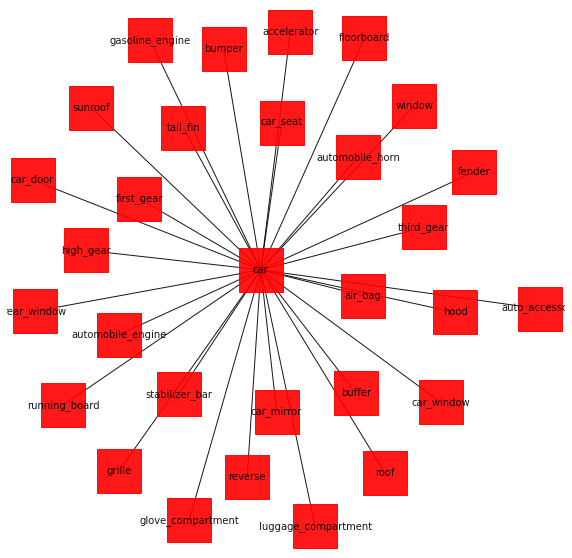

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')

nx.draw_networkx(G,with_labels=True,node_size=2000,
                 font_size=10,
                 node_shape='s',
                 alpha=0.9,
                 node_color='red')


Можно посчитать близость между синсетами (зависит от того, какой путь нужно пройти по этим связям от одного объекта до другого и есть ли он вообще)

In [ ]:
car = wn.synsets('car')[0]
bike = wn.synsets('bike')[0]

In [ ]:
bike.path_similarity(car)

0.3333333333333333

Есть и другие метрики:

In [ ]:
wn.lch_similarity(bike, car)

2.538973871058276

In [ ]:
wn.wup_similarity(bike, car)

0.9166666666666666

### Домашнее задание. Реализовать алгоритм Леска и проверить его на реальном датасете

Ворднет можно использовать для дизамбигуации. Самый простой алгоритм дизамбигуации - алгоритм Леска. В нём нужное значение слова находится через пересечение слов контекста, в котором употреблено это слово, с определениями значений слова из ворднета. Значение с максимальным пересечением - нужное.

Реализуйте его

In [ ]:
def count_overlap(sentence_a, sentence_b):
  return sum((Counter(sentence_a) & Counter(sentence_b)).values())

def lesk( word, sentence ):
    """Ваш код тут"""
    bestsense = 0
    maxoverlap = 0


    #ваш код
    synsets = wn.synsets(word)
    
    for i, syns in enumerate(synsets):
        # ваш код
        definition = syns.definition()
        if definition and type(definition)==str:
          definition = definition.lower().split()
          overlap = count_overlap(definition, sentence)
        else:
          overlap = 0
        
        if overlap > maxoverlap:
          maxoverlap = overlap
          bestsense = i
             
    return bestsense


Работать функция должна как-то так:

In [ ]:
# на вход подается элемент результата работы уже написанной вами функции get_words_in_context
lesk('day', 'some point or period in time'.split()) # для примера контекст совпадает с одним из определений
# а на выходе индекс подходящего синсета

1

In [ ]:
wn.synsets('day')

[Synset('day.n.01'),
 Synset('day.n.02'),
 Synset('day.n.03'),
 Synset('day.n.04'),
 Synset('day.n.05'),
 Synset('day.n.06'),
 Synset('day.n.07'),
 Synset('sidereal_day.n.01'),
 Synset('day.n.09'),
 Synset('day.n.10')]

In [ ]:
# с помощью этого индекса достаем нужный синсет
wn.synsets('day')[1].definition()

'some point or period in time'

**Проверьте насколько хорошо работает такой метод на реальном датасете.** http://lcl.uniroma1.it/wsdeval/ - большой фреймворк для оценки WSD. Там много данных и я взял кусочек, чтобы не было проблем с памятью

In [ ]:
corpus_wsd = []
corpus = open('corpus_wsd_50k.txt').read().split('\n\n')
for sent in corpus:
    corpus_wsd.append([s.split('\t') for s in sent.split('\n')])

Корпус состоит из предложений, где у каждого слова три поля - значение, лемма и само слово. Значение пустое, когда слово однозначное, а у многозначных слов стоит тэг вида **'long%3:00:02::'** Это тэг wordnet'ного формата

In [ ]:
corpus_wsd[0]

[['', 'how', 'How'],
 ['long%3:00:02::', 'long', 'long'],
 ['', 'have', 'has'],
 ['', 'it', 'it'],
 ['be%2:42:03::', 'be', 'been'],
 ['', 'since', 'since'],
 ['', 'you', 'you'],
 ['review%2:31:00::', 'review', 'reviewed'],
 ['', 'the', 'the'],
 ['objective%1:09:00::', 'objective', 'objectives'],
 ['', 'of', 'of'],
 ['', 'you', 'your'],
 ['benefit%1:21:00::', 'benefit', 'benefit'],
 ['', 'and', 'and'],
 ['service%1:04:07::', 'service', 'service'],
 ['program%1:09:01::', 'program', 'program'],
 ['', '?', '?']]

Вот так можно достать соответствующий этому тэгу синсет:

In [ ]:
wn.lemma_from_key('review%2:31:00::').synset()

Synset('review.v.01')

Когда с помощью алгоритма Леска вы найдете подходящее значение, их можно просто сравнить

In [ ]:
i = lesk('long', "It's a long story")
wn.synsets('long')[i]

Synset('long.a.01')

In [ ]:
# тут подходит второй синсет (!в вашем решении вместо индекса единицы будет результат работы функции lesk)
wn.synsets('long')[1] == wn.lemma_from_key('long%3:00:02::').synset()

True

In [ ]:
# можно сравнить со всеми, чтобы убедиться
[(syns, wn.synsets('long')[i] == wn.lemma_from_key('long%3:00:02::').synset()) 
  for i, syns in enumerate(wn.synsets('long'))]

[(Synset('hanker.v.01'), False),
 (Synset('long.a.01'), True),
 (Synset('long.a.02'), False),
 (Synset('long.s.03'), False),
 (Synset('retentive.a.01'), False),
 (Synset('long.a.05'), False),
 (Synset('long.a.06'), False),
 (Synset('long.s.07'), False),
 (Synset('farseeing.s.02'), False),
 (Synset('long.s.09'), False),
 (Synset('long.r.01'), False),
 (Synset('long.r.02'), False)]

**Вам нужно для каждого многозначного слова (т.е. у него есть тэг в первом поле) с помощью алгоритма Леска предсказать нужный синсет и сравнить с правильным. Посчитайте процент правильных предсказаний (accuracy).**

Если считается слишком долго, возьмите поменьше предложений (например, только тысячу)

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
all = 0
true = 0

for sent in tqdm_notebook(corpus_wsd, total=len(corpus_wsd)):
  sent = [i for i in sent if len(i)==3]

  for sense, lemma, word in sent:
    if sense:
      all += 1
      index = lesk(lemma, [token[2].lower() for token in sent])
      if wn.synsets(lemma)[index] == wn.lemma_from_key(sense).synset():
        true += 1

print(f'Accuracy: {true/all}')


Accuracy: 0.3326830976228883


### Дополнительный балл

Если хотите заработать дополнительный балл, попробуйте улучшить алгоритм Леска любым способом (например, использовать расстояние редактирования вместо пересечения или даже вставить машинное обучение)